## Inicialización

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import mean_squared_error

In [2]:
np.__version__ 

'1.21.2'

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
labels = pd.read_csv('faces/labels.csv')
display(labels.iloc)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


## EDA

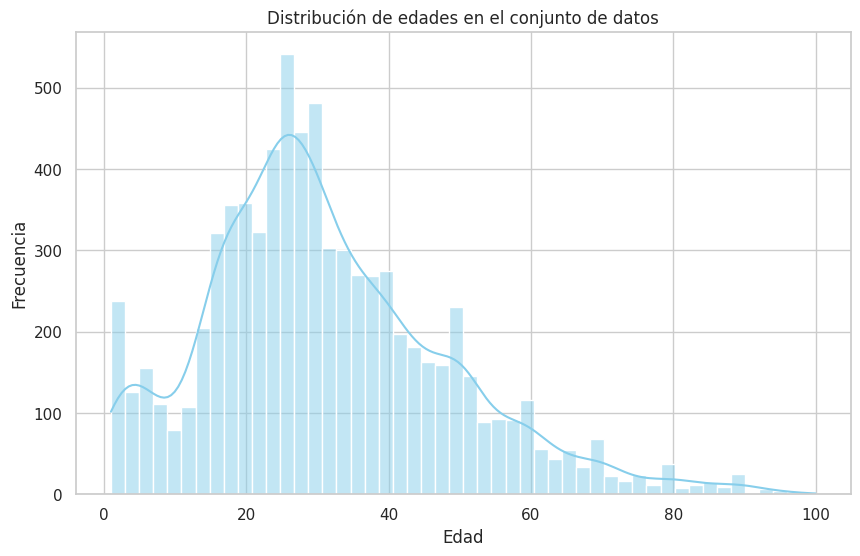

In [3]:
# Configurar estilo
sns.set(style="whitegrid")

# Graficar distribución de edades
plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=50, kde=True, color="skyblue")
plt.title("Distribución de edades en el conjunto de datos")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

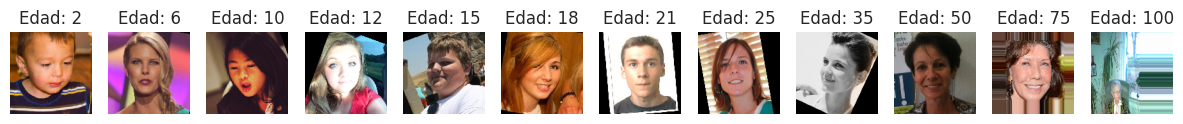

In [4]:
# Ruta de las imágenes
images_path = 'faces/final_files/'

# Función para mostrar imágenes para diferentes edades
def show_images_by_age(labels, ages_to_show, images_path, img_size=(128, 128)):
    plt.figure(figsize=(15, 5))
    for i, age in enumerate(ages_to_show):
        # Obtener un archivo para la edad específica
        file_name = labels[labels['real_age'] == age].sample(1)['file_name'].values[0]
        img_path = os.path.join(images_path, file_name)

        # Cargar y mostrar la imagen
        img = load_img(img_path, target_size=img_size)
        plt.subplot(1, len(ages_to_show), i+1)
        plt.imshow(img)
        plt.title(f"Edad: {age}")
        plt.axis("off")
    plt.show()

# Edades representativas
ages_to_show = [2, 6, 10, 12, 15, 18, 21, 25, 35, 50, 75, 100]

# Mostrar imágenes
show_images_by_age(labels, ages_to_show, images_path)

In [5]:
# Crear un generador para cargar imágenes
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [6]:
validation_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=images_path,
    x_col="file_name",
    y_col="real_age",
    target_size=(128, 128),
    batch_size=32,
    class_mode="raw",
    subset="validation"
)

Found 1518 validated image filenames.


### Conclusiones

* Se observa en la distribución que las edades que más aparecen están entre los 24 y los 32 años. Las que menos aparecen estan después de los 60 años, esto puede afectar en el entrenamiento de forma negativa ya que el modelo tiene más características de ciertas edades y menos de otras, estó puede hacer que el modelo sea bueno distinguiendo las edades con más características que las que tienen menos.
* Se pueden usar las técnicas estudiadas en este capítulo para uniformizar la catidad de características entre las edades, rotando, desplazando, entre otros, las imágenes para las edades con menos fotos de tal manera que la diferencia no sea significativa.
* Las fotos mostradas tienen diferentes ángulos, gestos, enfoques, luz, contrastes, etc... Lo anterior ayuda a que el modelo aprenda de mejor forma a distinguir edades.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    labels = pd.read_csv(f'{path}/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(128, 128),
        batch_size=32,
        class_mode="raw",
        subset="training"
    )

    return train_gen_flow

In [ ]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
    labels = pd.read_csv(f'{path}/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(128, 128),
        batch_size=32,
        class_mode="raw",
        subset="validation"
    )

    return test_gen_flow

In [ ]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1
    )
    return model, history

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [57]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import inspect

# Inicialización del script
init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
"""

# Definir funciones
def load_train(path):

    labels = pd.read_csv(f'{path}/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(128, 128),
        batch_size=32,
        class_mode="raw",
        subset="training"
    )
    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(f'{path}/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(128, 128),
        batch_size=32,
        class_mode="raw",
        subset="validation"
    )
    return test_gen_flow

def create_model(input_shape=(128, 128, 3)):

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=32, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1
    )
    return model, history

# Guardar script en archivo
with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')
    # Añadir sección de inicialización para ejecutarlo directamente
if __name__ == "__main__":
        dataset_path = '/datasets/faces'

        # Cargar datos
        train_data = load_train(dataset_path)
        test_data = load_test(dataset_path)

        # Crear modelo
        model = create_model()

        # Entrenar modelo
        trained_model, history = train_model(model, train_data, test_data, epochs=20)

        # Guardar modelo entrenado
        trained_model.save("age_prediction_model.h5")
        print("Entrenamiento completado y modelo guardado.")


Found 6073 validated image filenames.
Found 1518 validated image filenames.
94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/20
190/190 [==============================] - 513s 3s/step - loss: 397.1137 - mae: 15.2312 - val_loss: 290.4384 - val_mae: 13.5493
Epoch 2/20
190/190 [==============================] - 510s 3s/step - loss: 305.5558 - mae: 13.5273 - val_loss: 307.3145 - val_mae: 14.3350
Epoch 3/20
190/190 [==============================] - 508s 3s/step - loss: 303.6451 - mae: 13.5122 - val_loss: 288.1398 - val_mae: 13.4572
Epoch 4/20
190/190 [==============================] - 510s 3s/step - loss: 302.2027 - mae: 13.4371 - val_loss: 285.3430 - val_mae: 12.9706
Epoch 5/20
190/190 [==============================] - 516s 3s/step - loss: 296.9831 - mae: 13.3371 - val_loss: 287.8758 - val_mae: 13.4909
Epoch 6/20
190/190 [==============================] - 512s 3s/step - loss: 296.7931 - mae: 13.3323 - val_loss: 282.8250 - val_mae: 13.0744
Epoch 7/20
190/190 [=====

/opt/conda/envs/python3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Entrenamiento completado y modelo guardado.


In [3]:
from tensorflow.keras.models import load_model

model = load_model('age_prediction_model.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [42]:
# Relizamos la predicción
dataset_path = '/datasets/faces'
test_data = load_test(dataset_path)
train_data = load_train(dataset_path)
predicted_age = model.predict(test_data)

Found 1518 validated image filenames.
Found 6073 validated image filenames.


In [44]:
print(predicted_age)
print(test_data.labels)

[[28.310987]
 [31.709402]
 [29.959812]
 ...
 [29.554739]
 [32.516365]
 [33.411335]]
[ 4 18 80 ... 30 25 23]


### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

In [56]:
rmse = np.sqrt(mean_squared_error(test_data.labels, predicted_age))
print(f"RECM: {rmse:.2f}")

RECM: 17.05


# Conclusiones

1. El modelo se creo correctamente como: "age_prediction_model.h5" y el script como: "run_model_on_gpu.py"
2. El error RMSE es grande ya que es de 17.05 años lo que vuelve ineficiente la predicción de edades.
3. Lo anterior puede deberse, como se supuso en el análisis de las imagen, a la diferencia de tamaños de datos por edades, habiando muchas fotos de gente entre los 24 y 32 años, de hecho al analizar a fondo las predicciones, parece ser que las edades mejor predichas caen en el rango antes mencionado.
4. Se recomienda aplicar metodos de aumento de datos para las imágenes con edades de 1 a 23 y de 33 a 100 para regularizar la cantidad de características entre las edades y tener un conjuntos entrenamiento y prueba más uniforme